# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
%matplotlib notebook

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)
fontsmall = fm.FontProperties(fname = fontloc,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        
def xticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        
def yticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str("{0:.1f}".format(x)) if x < 0 else str("{0:.2f}".format(x))
    return label

In [2]:
#sample initial conditions
Toi = 0.0      #initial value
Tai = 0.0      #initial value
dTo = 1.000      #model error dev
dTa = 2.000      #model error dev

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.00 * tune
Coa = +1.00 * tune
Cao = +0.10 * tune
Caa = -1.00 * tune
m = 10.0

# define forcing function (weiner process with <cross-section>)
scale = 1.00          #relative amplitude of stochastic forcing
crosssec = scale * 1.0
interval = 1
#crosssec = 0.0

# time series
ini = 500             #initialisation
t_start = 0.0
t_end = 500.0 + ini
time_samples = 500 + ini
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = ini/(t_end - t_start)     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def func(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [3]:
import sdeint

# set white noise forcing amplitude
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

In [4]:
#solve the system of ODEs with a sample set of initial conditions
samples = 25
rand.seed(546)     #to fix initial conditions
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#calculate trajectories for all samples
VecCorr = []; LagCorr = []
for i in range(samples):
    x0 = []
    np.random.seed(int((i + 1) * m + 11))
    x0.append(np.random.normal(Toi, dTo, 1))
    np.random.seed(int((i + 1) * m + 21))
    x0.append(np.random.normal(Tai, dTa, 1))
    np.random.seed(int((i + 1) * m + 31))
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    VecCorr.append(crosscor); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    

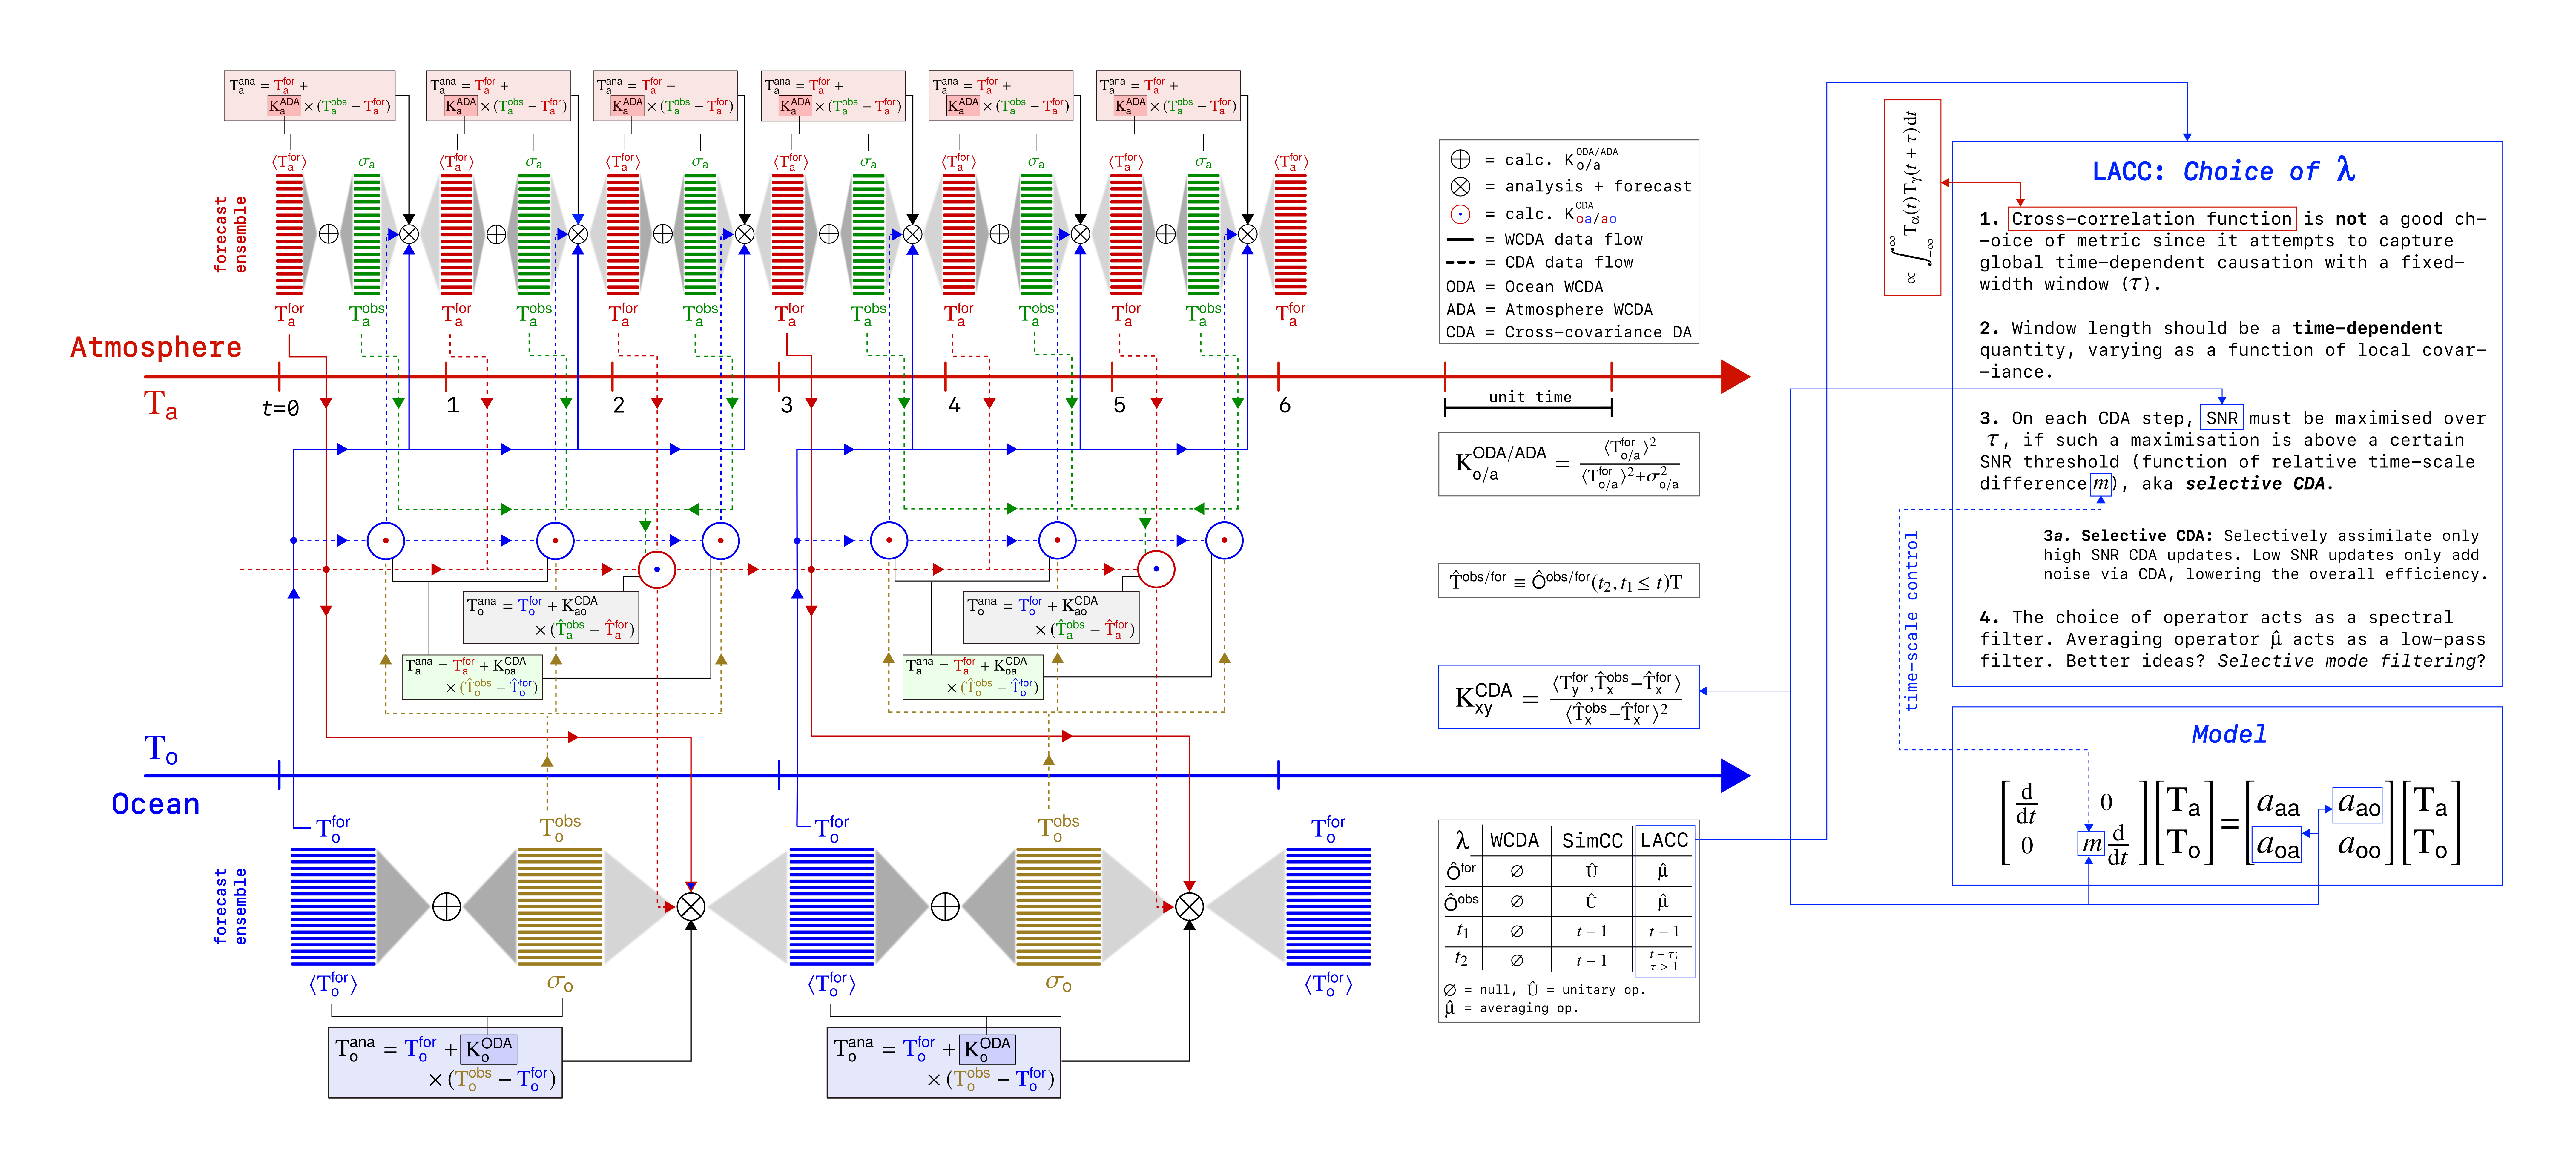

In [5]:
from IPython.display import Image
Image(filename=pwd + '/Liu15.png') 

# Leading average cross-correlation (LACC)

Considering LACC [[Lu15](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0)] and the results in previous section, the Kalman gain is maximised when the average of $\mathsf{N}$ leading atmospheric forecasts are selected for the analysis step in SCDA. This dependence of Kalman gain on leading forecasts is written as

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle}{\langle\overline{\mathsf{T_A}(t_1,t_2)}\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}} \propto \langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$$

where, $t_1 < t_2 \leq t$ contains $\mathsf{N}$ leading atmospheric forecasts and $\tau = |t_1 - t_2|$. In principle, in regions where the oceanic and atmopheric forecasts are strongly correlated, deviations from the forecasts, as obtained through observations, provide the highest signal-to-noise ratio (SNR) for the analysis step of the DA. This is the core ideology behind the [LACC](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0) method. For simplicity, we'll term the factor $\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$ as 'Kalman Gain', if/when required for simplicity.

Note: The <font color='blue'>KalGain()</font> function sets the DA step size equal to the peak cross-correlation lag time.

# Fourier space: 

Taking the fourier transform of the coupled set of ODEs:


$$\displaystyle2\pi i\mathsf{m} f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{OA}\hat{\mathsf{T}}_\mathsf{A}(f),$$

$$\displaystyle 2\pi i f\,\hat{\mathsf{T}}_\mathsf{A}(f) = \mathrm{C}_\mathsf{AO}\hat{\mathsf{T}}_\mathsf{O}(f) + \mathrm{C}_\mathsf{AA}\hat{\mathsf{T}}_\mathsf{A}(f) + \hat{\mathsf{F}}(f).$$

where, for white noise $\hat{\mathsf{F}}(f) = \gamma$ is a constant. Solving the set of equations in fourier space yields:

$$\hat{\mathsf{T}}_\mathsf{O}(f)=\gamma\frac{\mathrm{C}_\mathsf{OA}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

$$\hat{\mathsf{T}}_\mathsf{A}(f)=\gamma\frac{2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}}{(2\pi i f - \mathrm{C}_\mathsf{AA})(2\pi i\mathsf{m} f - \mathrm{C}_\mathsf{OO}) - \mathrm{C}_\mathsf{OA}\mathrm{C}_\mathsf{AO}}$$

Furthermore, equating 

$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow 0$$
and
$$|\hat{\mathsf{T}}_\mathsf{O}(f)|^2=|\hat{\mathsf{T}}_\mathsf{A}(f)|^2 \rightarrow \infty$$

gives the singular points in the fourier space. In particular, the $\infty$ is interesting.

**Kalman Gain**

Similarly the fourier transform of the Kalman Gain expression

$$\mathsf{K} = \frac{\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle}{\langle\overline{\mathsf{T_A}(t_1,t_2)}\rangle + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau}}$$

yields

$$\hat{\mathsf{K}}_\mathsf{L}(f) = \frac{\hat{\mathsf{T}}_\mathsf{O}(f)}{\bigg[ [\mathcal{F}(f)]^2 + \displaystyle\frac{\sigma_{\mathsf{A},\mathit{o}}^2}{\tau} \bigg]} \mathcal{F}(f)$$

where, $\mathcal{F}(f) = \langle$Sinc$(\pi f \tau)\, e^{-2\pi i f t_1} , \hat{\mathsf{T}}_\mathsf{A}(f)\rangle$, and $\tau=|t_1-t_2|$. This expression is a complete spectral description of the Kalman gain for the *LACC* method. 




In [6]:
import warnings
warnings.filterwarnings("error")

#set DA variables for LACC simulation
atm_dev = 2.000       #assumed standard deviation in atmospheric observations
oce_dev = 1.000       #assumed standard deviation in oceanic observations
atm_syn = 2.000       #to generate atmospheric observation vector
oce_syn = 1.000       #to generate oceanic observation vector
win = 21               #LACC      
Set = [0,1]           #[0,0] = None; [0,1] = mean(A) -> O; [1,0] = mean(O) -> A; [1,1] = Both mean(A) <-> mean(O)
NaN = np.float('nan')
CoolOff = 0           #wait before starting SCDA
time_stable = (ini + CoolOff)/(t_end - t_start)
t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

Inflate = 'Cov'
#ParaW = [0.00890556, -0.08185496, 0.00145241]
#ParaS = [0.09308653, -0.34092144, 0.00373398]

ParaO = [1.42780498, -0.45884889, 1.29612945]
ParaA = [0.22747331, -0.14821128,  1.5041001]

def expfit(var, param):     #calculate inflation using this
    y = (param[0] * np.exp(param[1] * var)) + param[-1]
    return y

def myround(x, base):
    return base * round(x/base)

def InflateIt(dT, Vec, ValTune, flag):
    if flag == 'Cov':
        Io = (dT[0]/np.std(Vec[0] - np.mean(Vec[0])))
        Ia = (dT[1]/np.std(Vec[1] - np.mean(Vec[1])))
        Io = 1.0; Ia = 1.0;
        oce_fat = ValTune[0] * Io * (Vec[0] - np.mean(Vec[0])) + np.mean(Vec[0])
        atm_fat = ValTune[1] * Ia * (Vec[1] - np.mean(Vec[1])) + np.mean(Vec[1])
        oce_fore = oce_fat; atm_fore = atm_fat
        VecIn = [Io, Ia]
    else:
        oce_fore = Vec[0]; atm_fore = Vec[1];
        VecIn = [NaN, NaN]
    return VecIn, oce_fore, atm_fore

def WCDA(To_l, Ta_l, t, win, samples, atm_dev, oce_dev):
    oce_for_c = np.zeros((samples, int(np.ceil(len(t)/win)))); oce_rmse = []
    atm_for_c = np.zeros((samples, int(np.ceil(len(t)/win)))); atm_rmse = []
    oce_for = np.zeros(np.array(To_l).shape); atm_for = np.zeros(np.array(To_l).shape)
    oce_ana = np.zeros(np.array(To_l).shape); atm_ana = np.zeros(np.array(To_l).shape)
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = []  
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0; Inflation = []
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop for <ini - 1> steps
            if num > 0:#offset
                for item in range(samples):
                    np.random.seed(int((num + 1) * (item + 1) * m * win) + 1)
                    if (num + 1) % interval == 0.0:
                        sol   = sdeint.itoint(unforc,forc,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    else:
                        sol   = odeint(func,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    oce_for[item,num] = sol[1,0]; atm_for[item,num] = sol[1,1]
                    oce_ana[item,num] = sol[1,0]; atm_ana[item,num] = sol[1,1]
            else:
                oce_for[:,num] = To_l[:,0]; atm_for[:,num] = Ta_l[:,0]
                oce_ana[:,num] = To_l[:,0]; atm_ana[:,num] = Ta_l[:,0]
            oce_rmse.append(np.sqrt(np.mean(np.square(oce_ana[:,num] - oce_tru[num]))))
            atm_rmse.append(np.sqrt(np.mean(np.square(atm_ana[:,num] - atm_tru[num]))))
            flag = 'None'
            if Inflate == 'Cov' or Inflate == 'TuneCov':
                Inflation.append([NaN, NaN])
            elif Inflate == 'Tune':
                Inflation.append(NaN)
        else:                    #start DA after <ini> time steps
            dTo_i = np.std(oce_for[:,num - 1]); dTa_i = np.std(atm_for[:,num - 1])
            Inflaton, X, Y = InflateIt([dTo_i, dTa_i], [oce_ana[:,num - 1], atm_ana[:,num - 1]], [expfit(m, ParaO), expfit(m, ParaA)], Inflate)
            Inflation.append([Inflaton[0], Inflaton[-1]])
            oce_ana[:,num - 1] = X; atm_ana[:,num - 1] = Y
            for item in range(samples):
                np.random.seed(int((num + 1) * (item + 1) * m * win) + 2)
                if (num + 1) % interval == 0.0:
                    sol   = sdeint.itoint(unforc,forc,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                else:
                    sol   = odeint(func,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                oce_for[item,num] = sol[1,0]; atm_for[item,num] = sol[1,1]   
            covar_matrix   = np.cov(np.array([oce_for[:,num], atm_for[:,num]]))
            var_atm   =   covar_matrix[1][1]
            var_oce   =   covar_matrix[0][0]
            Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
            Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
            oce_gain   = Ko * (oce_obs[:,num] - oce_for[:,num])
            atm_gain   = Ka * (atm_obs[:,num] - atm_for[:,num]) 
            KalGainO.append(Ko); KalGainA.append(Ka)
            ocean = oce_for[:,num] + oce_gain
            atmos = atm_for[:,num] + atm_gain
            oce_ana[:,num] = ocean; atm_ana[:,num] = atmos
            oce_rmse.append(np.sqrt(np.mean(np.square(oce_ana[:,num] - oce_tru[num]))))
            atm_rmse.append(np.sqrt(np.mean(np.square(atm_ana[:,num] - atm_tru[num]))))
            iter1 = iter1 + 1; iter0 = iter0 + 1
            
    return KalGainO, KalGainA, oce_for, atm_for, oce_rmse, atm_rmse, oce_ana, atm_ana, Inflation

def SCDA(To_l, Ta_l, t, win, samples, atm_dev, oce_dev):
    oce_for_c = np.zeros((samples, int(np.ceil(len(t)/win)))); oce_rmse = []
    atm_for_c = np.zeros((samples, int(np.ceil(len(t)/win)))); atm_rmse = []
    oce_for = np.zeros(np.array(To_l).shape); atm_for = np.zeros(np.array(To_l).shape)
    oce_ana = np.zeros(np.array(To_l).shape); atm_ana = np.zeros(np.array(To_l).shape)
    iter0 = 0; iter1 = 0; flag = 0; KalGainC = []; KalGainA = [] ; KalGainO = []; KalGainD = [] 
    oce_gain = 0; atm_gain = 0; oce_gain_c = 0; atm_gain_c = 0; Inflation = []; InflationC = [];
    for num, time in enumerate(t):
        if num < ini:  #initialisation loop for <ini - 1> steps, assumes win < ini
            if num > 0:#offset
                for item in range(samples):
                    np.random.seed(int((num + 1) * (item + 1) * m * win) + 1)
                    if (num + 1) % interval == 0.0:
                        sol   = sdeint.itoint(unforc,forc,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    else:
                        sol   = odeint(func,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    oce_for[item,num] = sol[1,0]; atm_for[item,num] = sol[1,1]
                    oce_ana[item,num] = sol[1,0]; atm_ana[item,num] = sol[1,1]
            else:
                oce_for[:,num] = To_l[:,0]; atm_for[:,num] = Ta_l[:,0]
                oce_ana[:,num] = To_l[:,0]; atm_ana[:,num] = Ta_l[:,0]
            oce_rmse.append(np.sqrt(np.mean(np.square(oce_ana[:,num] - oce_tru[num]))))
            atm_rmse.append(np.sqrt(np.mean(np.square(atm_ana[:,num] - atm_tru[num]))))
            flag = 'None'
            if Inflate == 'Cov' or Inflate == 'TuneCov':
                Inflation.append([NaN, NaN])
            elif Inflate == 'Tune':
                Inflation.append(NaN)
            if time % win == 0.0:
                if num > 0:
                    if Set[0] == 0 and Set[-1] == 0:
                        oce_for_c[:,iter0] = oce_for[:,num]; atm_for_c[:,iter0] = atm_for[:,num]
                    elif Set[0] == 0 and Set[-1] == 1:
                        atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                        oce_for_c[:,iter0] = oce_for[:,num]
                    elif Set[0] == 1 and Set[-1] == 0:
                        oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                        atm_for_c[:,iter0] = atm_for[:,num]
                    elif Set[0] == 1 and Set[-1] == 1:
                        atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                        oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                    else:
                        error('Illegal Input')
                else:
                    oce_for_c[:,iter0] = oce_for[:,0]
                    atm_for_c[:,iter0] = atm_for[:,0]
                iter0 = iter0 + 1
        else:                    #start DA after <ini> time steps
            if time % win == 0.0 and num > win - 1 and num - ini >= CoolOff: 
                dTo_i = np.std(oce_for[:,num - 1]); dTa_i = np.std(atm_for[:,num - 1])
                Inflaton, X, Y = InflateIt([dTo_i, dTa_i], [oce_ana[:,num - 1], atm_ana[:,num - 1]], [expfit(m, ParaO), expfit(m, ParaA)], Inflate)
                Inflation.append([Inflaton[0], Inflaton[-1]])
                oce_ana[:,num - 1] = X; atm_ana[:,num - 1] = Y
                for item in range(samples):
                    np.random.seed(int((num + 1) * (item + 1) * m * win) + 3)
                    if (num + 1) % interval == 0.0:
                        sol   = sdeint.itoint(unforc,forc,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    else:
                        sol   = odeint(func,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    oce_for[item,num] = sol[1,0]; atm_for[item,num] = sol[1,1]
                if Set[0] == 0 and Set[-1] == 0:
                    oce_for_c[:,iter0] = oce_for[:,num]; atm_for_c[:,iter0] = atm_for[:,num]
                    atm_de2 = atm_dev; oce_de2 = oce_dev
                elif Set[0] == 0 and Set[-1] == 1:
                    atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                    oce_for_c[:,iter0] = oce_for[:,num]
                    atm_de2 = atm_dev/np.sqrt(win); oce_de2 = oce_dev
                elif Set[0] == 1 and Set[-1] == 0:
                    oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                    atm_for_c[:,iter0] = atm_for[:,num]
                    atm_de2 = atm_dev; oce_de2 = oce_dev/np.sqrt(win)
                elif Set[0] == 1 and Set[-1] == 1:
                    atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                    oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                    atm_de2 = atm_dev/np.sqrt(win); oce_de2 = oce_dev/np.sqrt(win)
                else:
                    error('Illegal Input')
                    
                #cross update
                covar_matrix_c   = np.cov(np.array([oce_for_c[:,iter0], atm_for_c[:,iter0]]))
                atm_mean = atm_for_c[:,iter0]; oce_mean = oce_for_c[:,iter0]
                covar_c   = covar_matrix_c[0][1]
                var_atm_c = covar_matrix_c[1][1]
                var_oce_c = covar_matrix_c[0][0]
                D  = (((var_oce_c) + (oce_de2)**2)*((var_atm_c) + (atm_de2)**2) - (covar_c**2))
                Kc = (covar_c*((oce_de2)**2))/D
                Kd = (covar_c*((atm_de2)**2))/D
                Ka = ((var_atm_c)*(var_oce_c + (oce_de2)**2) - (covar_c**2))/D
                Ko = ((var_oce_c)*(var_atm_c + (atm_de2)**2) - (covar_c**2))/D
                if Set[0] == 0 and Set[-1] == 0:
                    atm_gain_c = 0.0; oce_gain_c = 0.0
                elif Set[0] == 0 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs_mean[:][iter0] - atm_for_c[:,iter0])
                    atm_gain_c = 0.0
                elif Set[0] == 1 and Set[-1] == 0:
                    oce_gain_c = 0.0
                    atm_gain_c = Kd * (oce_obs_mean[:][iter0] - oce_for_c[:,iter0])
                elif Set[0] == 1 and Set[-1] == 1:
                    oce_gain_c = Kc * (atm_obs_mean[:][iter0] - atm_for_c[:,iter0])
                    atm_gain_c = Kd * (oce_obs_mean[:][iter0] - oce_for_c[:,iter0])
                else:                    
                    error('Illegal Input')
                oce_gain   = Ko * (oce_obs[:,num] - oce_for[:,num])
                atm_gain   = Ka * (atm_obs[:,num] - atm_for[:,num])
                KalGainD.append(Kd); KalGainC.append(Kc); KalGainO.append(Ko); KalGainA.append(Ka)
                ocean = oce_for[:,num] + oce_gain_c + oce_gain
                atmos = atm_for[:,num] + atm_gain_c + atm_gain
                oce_ana[:,num] = ocean; atm_ana[:,num] = atmos
                oce_rmse.append(np.sqrt(np.mean(np.square(oce_ana[:,num] - oce_tru[num]))))
                atm_rmse.append(np.sqrt(np.mean(np.square(atm_ana[:,num] - atm_tru[num]))))
                iter1 = iter1 + 1; iter0 = iter0 + 1
            else:
                if num - ini < CoolOff:
                    if time % win == 0.0:
                        if Set[0] == 0 and Set[-1] == 0:
                            oce_for_c[:,iter0] = oce_for[:,num]; atm_for_c[:,iter0] = atm_for[:,num]
                        elif Set[0] == 0 and Set[-1] == 1:
                            atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                            oce_for_c[:,iter0] = oce_for[:,num]
                        elif Set[0] == 1 and Set[-1] == 0:
                            oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                            atm_for_c[:,iter0] = atm_for[:,num]
                        elif Set[0] == 1 and Set[-1] == 1:
                            atm_for_c[:,iter0] = np.mean(atm_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for atmos
                            oce_for_c[:,iter0] = np.mean(oce_for[:,num - win + 1:num + 1],axis=1)   #mean over previous <win> times for ocean
                        else:
                            error('Illegal Input')
                        if Inflate == 'Cov':
                            #should add inflation for these buffer steps later
                            None
                        elif Inflate == 'Tune':
                            None
                        iter0 = iter0 + 1
                dTo_i = np.std(oce_for[:,num - 1]); dTa_i = np.std(atm_for[:,num - 1])
                Inflaton, X, Y = InflateIt([dTo_i, dTa_i], [oce_ana[:,num - 1], atm_ana[:,num - 1]], [expfit(m, ParaO), expfit(m, ParaA)], Inflate)
                Inflation.append([Inflaton[0], Inflaton[-1]])
                oce_ana[:,num - 1] = X; atm_ana[:,num - 1] = Y
                for item in range(samples):
                    np.random.seed(int((num + 1) * (item + 1) * m * win) + 2)
                    if (num + 1) % interval == 0.0:
                        sol   = sdeint.itoint(unforc,forc,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    else:
                        sol   = odeint(func,[oce_ana[item,num - 1],atm_ana[item,num - 1]],[0,1])
                    oce_for[item,num] = sol[1,0]; atm_for[item,num] = sol[1,1]
                covar_matrix   = np.cov(np.array([oce_for[:,num], atm_for[:,num]]))
                var_oce = covar_matrix[0][0]
                var_atm = covar_matrix[1][1]
                Ka = ((var_atm))/((var_atm) + (atm_dev)**2)
                Ko = ((var_oce))/((var_oce) + (oce_dev)**2)
                oce_gain   = Ko * (oce_obs[:,num] - oce_for[:,num])
                atm_gain   = Ka * (atm_obs[:,num] - atm_for[:,num])
                KalGainO.append(Ko); KalGainA.append(Ka)
                KalGainC.append(0.0); KalGainD.append(0.0)
                oce_gain_c = 0; atm_gain_c = 0
                ocean = oce_for[:,num] + oce_gain_c + oce_gain
                atmos = atm_for[:,num] + atm_gain_c + atm_gain
                oce_ana[:,num] = ocean; atm_ana[:,num] = atmos
                oce_rmse.append(np.sqrt(np.mean(np.square(oce_ana[:,num] - oce_tru[num]))))
                atm_rmse.append(np.sqrt(np.mean(np.square(atm_ana[:,num] - atm_tru[num]))))
    return KalGainD, KalGainC, KalGainO, KalGainA, oce_for, atm_for, oce_rmse, atm_rmse, oce_ana, atm_ana, Inflation

KalDecMat = []; KalCovMat = []; KalAMat   = []; KalOMat   = []
atm_obs   = [];   oce_obs = []

#read observation file
To_s = []; Ta_s = []
with open(pwd + '/ToyModel_1/Data/Oce_N_obs_' + str(int(m)) + '.log') as f:
    for line in f.readlines():
          To_s.append(float(line))
with open(pwd + '/ToyModel_1/Data/Atm_N_obs_' + str(int(m)) + '.log') as f:
    for line in f.readlines():
          Ta_s.append(float(line))
            
#fix truth as one of the many possibilities
np.random.seed(int(m) + 12)
atm_tru = [val + noi for val, noi in zip(Ta_s, np.random.normal(0.0, atm_syn, len(t)))]
np.random.seed(int(m) + 22)
oce_tru = [val + noi for val, noi in zip(To_s, np.random.normal(0.0, oce_syn, len(t)))]              

#perturb ocean ensemble
atm_obs = np.zeros((samples, len(t))); oce_obs = np.zeros((samples, len(t))); 
for i in range(samples):
    np.random.seed(int((i + 1) * m) + 12)
    atm_obs[i,:] = [val + noi for val, noi in zip(Ta_s, np.random.normal(0.0, atm_dev, len(t)))]     #atmos obs vector
    np.random.seed(int((i + 1) * m) + 22)
    oce_obs[i,:] = [val + noi for val, noi in zip(To_s, np.random.normal(0.0, oce_dev, len(t)))]     #ocean obs vector

oce_obs_mean = []; atm_obs_mean = []
for num, time in enumerate(t):
    if time % win == 0.0:      #mean vector atmos
        if num > win - 1:   
            if Set[0] == 0 and Set[-1] == 0:
                oce_obs_mean.append(oce_obs[:,num])
                atm_obs_mean.append(atm_obs[:,num])
            elif Set[0] == 0 and Set[-1] == 1:
                atm_obs_mean.append(np.mean(atm_obs[:,num - win + 1:num + 1],axis=1))   #mean over previous <win> times for atmos
                oce_obs_mean.append(oce_obs[:,num])
            elif Set[0] == 1 and Set[-1] == 0:
                oce_obs_mean.append(np.mean(oce_obs[:,num - win + 1:num + 1],axis=1))   #mean over previous <win> times for ocean
                atm_obs_mean.append(atm_obs[:,num])
            elif Set[0] == 1 and Set[-1] == 1:
                atm_obs_mean.append(np.mean(atm_obs[:,num - win + 1:num + 1],axis=1))   #mean over previous <win> times for atmos
                oce_obs_mean.append(np.mean(oce_obs[:,num - win + 1:num + 1],axis=1))   #mean over previous <win> times for ocean   
            else:
                error('Illegal Input')
        else:
            atm_obs_mean.append(atm_obs[:,0]); oce_obs_mean.append(oce_obs[:,0])

            
KalCovDec, KalCovVec, KalOVec, KalAVec, oce_forS, atm_forS, oce_rmseS, atm_rmseS, oce_anaS, atm_anaS, InflationS = SCDA(np.array(To_l), np.array(Ta_l), t, win, samples, atm_dev, oce_dev)
KalOVecW,  KalAVecW,                    oce_forW, atm_forW, oce_rmseW, atm_rmseW, oce_anaW, atm_anaW, InflationW = WCDA(np.array(To_l), np.array(Ta_l), t, win, samples, atm_dev, oce_dev) 
                                                                       #passing win=1 ensures SimCC method

    
time_ignore = int(np.floor(time_stable*len(t)))                        #ignore fraction of preceding analysis 
KalDecMat = KalCovDec; KalCovMat = KalCovVec; KalAMat = KalAVec; KalOMat = KalOVec
oce_for_saveS = oce_forS; atm_for_saveS = atm_forS
oce_for_saveW = oce_forW; atm_for_saveW = atm_forW
oce_ana_saveS = oce_anaS; atm_ana_saveS = atm_anaS
oce_ana_saveW = oce_anaW; atm_ana_saveW = atm_anaW  
    
time_stab     = t[time_ignore:]

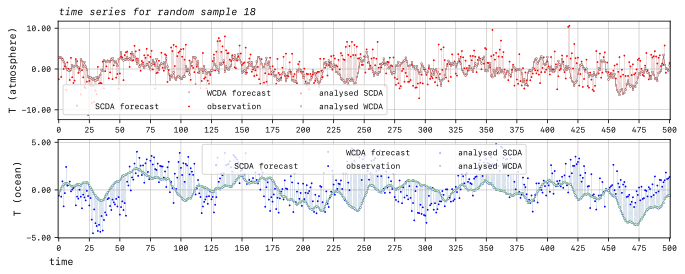

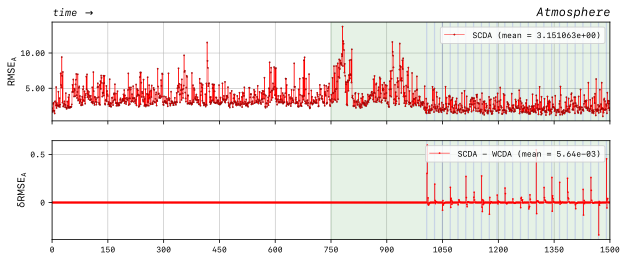

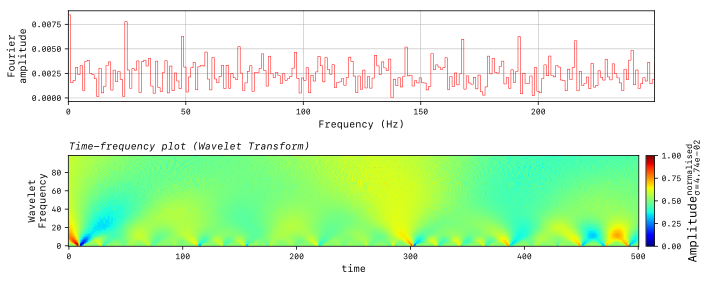

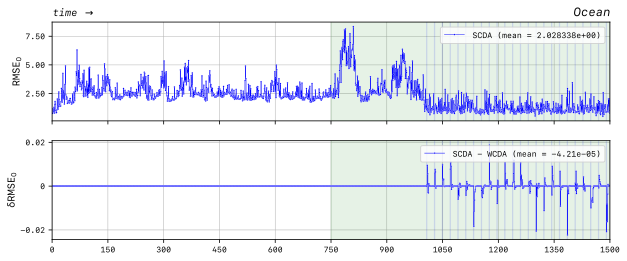

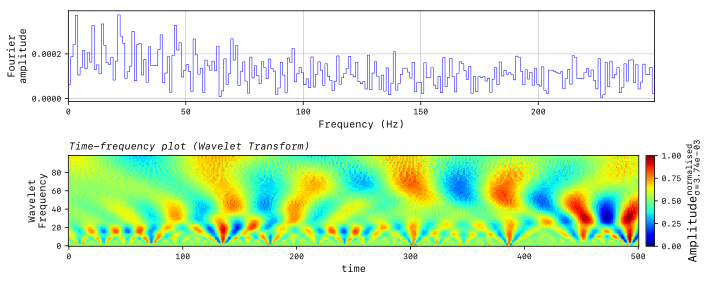

In [7]:
# plot sample time series and RMSE
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pywt
%config InlineBackend.figure_format = 'svg'
#%matplotlib notebook

def scale(X, x_min, x_max):
    nom   = (-X + max(map(max, X)))*(x_max - x_min)
    denom = max(map(max, X)) - min(map(min, X))
    denom = np.array(denom)
    denom[denom == 0] = 1
    return x_min + nom/denom

randsamp = np.random.randint(0,samples)
time_plot = [0, 500]
#time_plot = [int(t[0]), int(t[-1])]
stepping  = (time_plot[-1] - time_plot[0])/20

#plot a sample trajectory
fig = plt.figure(figsize=(11,4), dpi=100);
#--Atmopshere
plt.subplot(2, 1, 1)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = atm_ana_saveS[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = atm_for_saveS[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = atm_obs[randsamp][time_plot[0]:time_plot[-1] + 1]
y4 = Ta_l[randsamp][time_plot[0]:time_plot[-1] + 1]; y5 = atm_for_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
y7 = atm_ana_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
plt.plot(   t_s, y4, '--r', linewidth=0.5, alpha = 0.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='r', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='r', alpha = 1.0, facecolor='w', linewidth=0.2);
plt.scatter(t_s, y7, marker='v', s=3, edgecolor='k', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.step(   t_s, y2,  'r', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='r', markeredgewidth=0.2);
plt.step(   t_s, y5,  'k', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y7[i],y5[i],y3[i]), max(y7[i],y5[i],y3[i])], '--k', linewidth=0.1, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i]], [min(y1[i],y2[i],y3[i]), max(y1[i],y2[i],y3[i])], '--r', linewidth=0.1, zorder=0, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y7[i], y5[i + 1]], '-k', linewidth=0.2, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-r', linewidth=0.2, zorder=0, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('T (atmosphere)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['', 'SCDA forecast','WCDA forecast','observation','analysed SCDA', 'analysed WCDA'], loc='best', ncol=3)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('time series for random sample ' + str(randsamp), fontproperties=fontit,fontsize=10, y=1.00, loc='left');
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
#--Ocean
plt.subplot(2, 1, 2)
t_s = t[time_plot[0]:time_plot[-1] + 1]; y1 = oce_ana_saveS[randsamp][time_plot[0]:time_plot[-1] + 1] 
y2 = oce_for_saveS[randsamp][time_plot[0]:time_plot[-1] + 1]; y3 = oce_obs[randsamp][time_plot[0]:time_plot[-1] + 1]
y4 = To_l[randsamp][time_plot[0]:time_plot[-1] + 1]; y5 = oce_for_saveW[randsamp][time_plot[0]:time_plot[-1] + 1]
y7 = oce_ana_saveW[randsamp][time_plot[0]:time_plot[-1] + 1] 
plt.plot(   t_s, y4, '--b', linewidth=0.5, alpha = 0.0, drawstyle='steps-post', marker='.', markersize=0.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
plt.scatter(t_s, y3, marker='.', s=3, c='b', alpha = 1.0);
plt.scatter(t_s, y1, marker='^', s=3, edgecolor='b', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.scatter(t_s, y7, marker='v', s=3, edgecolor='g', alpha = 1.0, facecolor='w', linewidth=0.2, zorder=2);
plt.step(   t_s, y2,  'b', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='b', markeredgewidth=0.2);
plt.step(   t_s, y5,  'g', linewidth=0.0, alpha = 1.0, where='pre', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
for i in range(0, len(t_s)):
    plt.plot([t_s[i], t_s[i]], [min(y7[i],y5[i],y3[i]), max(y7[i],y5[i],y3[i])], '--g', linewidth=0.1, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i]], [min(y1[i],y2[i],y3[i]), max(y1[i],y2[i],y3[i])], '--b', linewidth=0.1, zorder=1, label='_nolegend_')
for i in range(0, len(t_s) - 1):
    plt.plot([t_s[i], t_s[i + 1]], [y7[i], y5[i + 1]], '-g', linewidth=0.2, zorder=0, label='_nolegend_')
    plt.plot([t_s[i], t_s[i + 1]], [y1[i], y2[i + 1]], '-b', linewidth=0.2, zorder=1, label='_nolegend_')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.xlabel('time'      ,fontproperties=font,fontsize=10);
plt.ylabel('T (ocean)' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.2)
l1 = ax.legend(['', 'SCDA forecast','WCDA forecast','observation','analysed SCDA', 'analysed WCDA'], loc='best', ncol=3)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.setp(ax.get_xticklabels(), visible=True)
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')

#plot RMSE
time_plot = [int(t[0]), int(t[-1])]
#time_plot = [2900, 3000]
stepping  = (time_plot[-1] - time_plot[0])/10
half      = int(round(time_plot[-1] - (time_plot[-1] - time_plot[0])/2))
fig = plt.figure(figsize=(10,4), dpi=100);
#--Atmopshere
plt.subplot(2, 1, 1)
meanS = np.mean(atm_rmseS[half:time_plot[-1] + 1])
meanW = np.mean(atm_rmseW[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], atm_rmseS[time_plot[0]:time_plot[-1] + 1], 'r', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='r', markeredgecolor='k', markeredgewidth=0.2);
plt.step(t[time_plot[0]:time_plot[-1] + 1], atm_rmseW[time_plot[0]:time_plot[-1] + 1], 'k', linewidth=0.5, alpha = 0.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel(r'RMSE$\mathregular{_A}$' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(meanS)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title(r'time $\rightarrow$', fontproperties=fontit,fontsize=10, y=1.00, loc='left');
plt.setp(ax.get_xticklabels(), visible=False)
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
plt.axvspan(half, int(t[-1]), alpha=0.1, color='green');
ax.set_title('Atmosphere', fontproperties=fontit,fontsize=12, y=1.0, loc='right');
        
diff_atm_rmse = [(i - j) for i,j in zip(atm_rmseS, atm_rmseW)]
plt.subplot(2, 1, 2)
mean  = np.mean(diff_atm_rmse[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], diff_atm_rmse[time_plot[0]:time_plot[-1] + 1], 'r', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='r', markeredgecolor='r', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.ylabel(r'$\mathregular{\delta}$RMSE$\mathregular{_A}$' ,fontproperties=font,fontsize=10);
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA - WCDA (mean = ' + str("{:.2e}".format(mean)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
plt.setp(ax.get_xticklabels(), visible=True)
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
plt.axvspan(half, int(t[-1]), alpha=0.1, color='green');

fig = plt.figure(figsize=(10,4), dpi=100);  
plt.subplot(2, 1, 1)
Y = diff_atm_rmse[time_ignore:]
FFT = []; FQ = []
T = len(Y)
F = np.fft.fft(Y)
FFT = np.abs(F)[:T // 2] * 1 / T
Q  = np.linspace(0, T, T)
FQ = Q[:T // 2]
plt.plot(np.array(FQ), FFT, c='r', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel(r'Fourier' + "\n" + 'amplitude',fontproperties=font,fontsize=10);
plt.xlabel('Frequency (Hz)',fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);

ax = plt.subplot(2, 1, 2)
sig  = Y
widths = np.arange(1, 100)
cwtmatr, freqs = pywt.cwt(sig, widths,'gaus1');
dev = np.std(cwtmatr)
cwtmatr = scale(cwtmatr, 0, 1)
ticks(ax,8); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
im = ax.matshow(np.array(cwtmatr),origin='lower',cmap='jet',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1.5%", pad = 0.1)
cb = plt.colorbar(im, cax=cax, label=r'Amplitude$\mathregular{{ }^{normalised}_{\sigma = %1.2e}}$' %dev,orientation="vertical");
axc = cb.ax; text = axc.yaxis.label
text.set_font_properties(proplr)
ticks(axc,8); ax.set_xlabel('time',fontproperties=font,fontsize=10);
ax.set_ylabel(r'Wavelet' + "\n" + 'Frequency',fontproperties=font,fontsize=10);
ax.set_title('Time-frequency plot (Wavelet Transform)', fontproperties=fontit,fontsize=10, y=1.0, loc='left');
ax.xaxis.set_ticks_position('bottom'); 
plt.tight_layout()

fig = plt.figure(figsize=(10,4), dpi=100);  
#--Ocean
plt.subplot(2, 1, 1)
meanS = np.mean(oce_rmseS[half:time_plot[-1] + 1])
meanW = np.mean(oce_rmseW[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmseS[time_plot[0]:time_plot[-1] + 1], 'b', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='b', markeredgecolor='w', markeredgewidth=0.2);
plt.step(t[time_plot[0]:time_plot[-1] + 1], oce_rmseW[time_plot[0]:time_plot[-1] + 1], 'g', linewidth=0.5, alpha = 0.0, where='mid', marker='.', markersize=3.0, markerfacecolor='w', markeredgecolor='g', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.ylabel('ocean' ,fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.ylabel(r'RMSE$\mathregular{_O}$' ,fontproperties=font,fontsize=10);
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA (mean = ' + str("{:.6e}".format(meanS)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title(r'time $\rightarrow$', fontproperties=fontit,fontsize=10, y=1.00, loc='left');
plt.setp(ax.get_xticklabels(), visible=False)
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
plt.axvspan(half, int(t[-1]), alpha=0.1, color='green');
ax.set_title('Ocean', fontproperties=fontit,fontsize=12, y=1.0, loc='right');
        
        
diff_oce_rmse = [(i - j) for i,j in zip(oce_rmseS, oce_rmseW)]
plt.subplot(2, 1, 2)
mean  = np.mean(diff_oce_rmse[half:time_plot[-1] + 1])
plt.step(t[time_plot[0]:time_plot[-1] + 1], diff_oce_rmse[time_plot[0]:time_plot[-1] + 1], 'b', linewidth=0.5, alpha = 1.0, where='mid', marker='.', markersize=3.0, markerfacecolor='b', markeredgecolor='w', markeredgewidth=0.2);
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
plt.ylabel(r'$\mathregular{\delta}$RMSE$\mathregular{_O}$' ,fontproperties=font,fontsize=10);
plt.xticks(range(time_plot[0], time_plot[-1] + 1, int(stepping))); ax.xaxis.set_label_coords(0.005, -0.1)
l1 = ax.legend(['SCDA - WCDA (mean = ' + str("{:.2e}".format(mean)) + ')'], loc='upper right', ncol=2)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
for l in range(int(t[0]), int(t[-1]), win):
    if time_plot[0] <= l <= time_plot[-1] and l >= ini + CoolOff:
        plt.axvspan(l - 1, l, alpha=0.1, color='blue')
plt.axvspan(half, int(t[-1]), alpha=0.1, color='green');
    
fig = plt.figure(figsize=(10,4), dpi=100);
plt.subplot(2, 1, 1)
Y = diff_oce_rmse[time_ignore:]
FFT = []; FQ = []
T = len(Y)
F = np.fft.fft(Y)
FFT = np.abs(F)[:T // 2] * 1 / T
Q  = np.linspace(0, T, T)
FQ = Q[:T // 2]
plt.plot(np.array(FQ), FFT, c='b', linewidth=0.5, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel(r'Fourier' + "\n" + 'amplitude',fontproperties=font,fontsize=10);
plt.xlabel('Frequency (Hz)',fontproperties=font,fontsize=10);
ax.autoscale(enable=True, axis='x', tight=True);

ax = plt.subplot(2, 1, 2)
sig  = Y
widths = np.arange(1, 100)
cwtmatr, freqs = pywt.cwt(sig, widths,'morl');
dev = np.std(cwtmatr)
cwtmatr = scale(cwtmatr, 0, 1)
ticks(ax,8); ax.set_axisbelow(True)
ax.autoscale(enable=True, axis='x', tight=True);
im = ax.matshow(np.array(cwtmatr),origin='lower',cmap='jet',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1.5%", pad = 0.1)
cb = plt.colorbar(im, cax=cax, label=r'Amplitude$\mathregular{{ }^{normalised}_{\sigma = %1.2e}}$' %dev,orientation="vertical");
axc = cb.ax; text = axc.yaxis.label
text.set_font_properties(proplr)
ticks(axc,8); ax.set_xlabel('time',fontproperties=font,fontsize=10);
ax.set_ylabel(r'Wavelet' + "\n" + 'Frequency',fontproperties=font,fontsize=10);
ax.set_title('Time-frequency plot (Wavelet Transform)', fontproperties=fontit,fontsize=10, y=1.0, loc='left');
ax.xaxis.set_ticks_position('bottom'); 
plt.tight_layout()


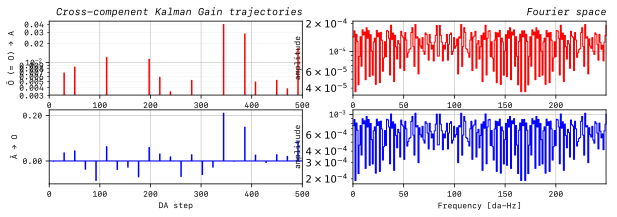

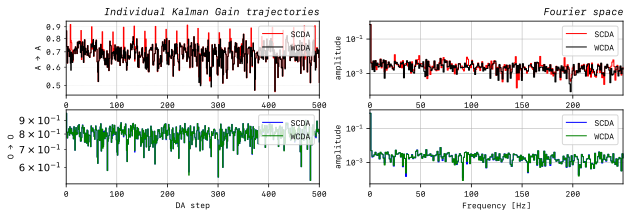

In [8]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm
import unicodedata
%matplotlib inline

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def stretch_to(l, n, insert):
    Out = [insert] * n
    m = len(l)
    if m == 1:
        m = 2
    for i, x in enumerate(l):
        Out[i * (n - 1) // (m - 1)] = x
    return Out

NaN = float('nan')

if 0 == 1:
    #stretched list
    KalCovLong = []
    for row in KalCovMatRaw:
        row_long = stretch_to(row, renorm, NaN)
        row_new = fill_nan(np.array(row_long))
        KalCovLong.append(row_new)

    #make rows equal lengths for plotting
    maxLen = max(map(len, KalCovMat))
    for row in KalCovMat:
        if len(row) < maxLen:
            row.extend(NaN for _ in range(maxLen - len(row)))

    #draw trajectories of Cross-Corr
    fig, ax = plt.subplots(figsize=(40,40), dpi=200);
    #PlotMat = np.array(KalCovMat).transpose()
    PlotMat = np.array(KalCovMat)
    im = ax.matshow(PlotMat,origin='lower');
    ax.grid(which='minor')
    ax.set_aspect(1.0)

    #colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="3%", pad = 0.1)
    cb = plt.colorbar(im, cax=cax,label='Kalman Gain',orientation="horizontal");
    axc = cb.ax
    text = axc.xaxis.label
    text.set_font_properties(proplr)
    ticks(axc,10);

    ax.set_xlabel('DA step',fontproperties=font,fontsize=12); 
    ax.xaxis.set_label_position('top');
    ax.set_ylabel('sample number',fontproperties=font,fontsize=12); 

    ticks(ax,10);
    ax.set_title('Kalman Gain trajectories',fontproperties=fontit,fontsize=12, y=1.15, loc='left');

#--Cov plots
time_plot = [0, 500]   #days
freq_plot = [0, 500]   #Hz

#Atmosphere to Ocean Cross-component
plt.figure(figsize=(10,3),dpi=100);
plt.subplot(2, 2, 3)
plt.plot(KalCovMat[time_plot[0]:time_plot[-1] + 1], c='b', linewidth=1.00, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('Ā ' + u"\u2192" + ' O',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('DA step',fontproperties=font,fontsize=8);
#ax.set_yscale('log');
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);
#frequency space
FFT = []; FQ = []
T = len(KalCovMat)
F = np.fft.fft(KalCovMat)
FFT = np.abs(F)[:T // 2] * 1 / T
Q  = np.linspace(0, T, T)
FQ = Q[:T // 2]
plt.subplot(2, 2, 4)
plt.plot(np.array(FQ[freq_plot[0]:freq_plot[-1] + 1]), FFT[freq_plot[0]:freq_plot[-1] + 1], c='b', linewidth=1.00, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log'); 
plt.xlabel('Frequency [da-Hz]',fontproperties=font,fontsize=8);

#Ocean to Atmosphere Cross-component
plt.subplot(2, 2, 1)
plt.plot(KalDecMat[time_plot[0]:time_plot[-1] + 1], c='r', linewidth=1.00, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('Ō (= O) ' + u"\u2192" + ' A',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Cross-compenent Kalman Gain trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_yscale('log');
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);

#frequency space
FFT = []; FQ = []
T = len(KalDecMat)
F = np.fft.fft(KalDecMat)
FFT = np.abs(F)[:T // 2] * 1 / T
Q  = np.linspace(0, T, T)
FQ = Q[:T // 2]
plt.subplot(2, 2, 2)
plt.plot(np.array(FQ[freq_plot[0]:freq_plot[-1] + 1]), FFT[freq_plot[0]:freq_plot[-1] + 1], c='r', linewidth=1.00, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Fourier space',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.set_yscale('log'); plt.savefig("/Users/asi066/Desktop/figure3.png",dpi=200)

plt.figure(figsize=(10,3),dpi=100);
#--Atmosphere
plt.subplot(2, 2, 1)
plt.plot(KalAMat[time_plot[0]:time_plot[-1] + 1],    c='red', linewidth=1.00, drawstyle='steps-post')
plt.plot(KalAVecW[time_plot[0]:time_plot[-1] + 1], c='black', linewidth=1.00, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
plt.ylabel('A ' + u"\u2192" + ' A',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Individual Kalman Gain trajectories',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
l1 = ax.legend(['SCDA', 'WCDA'], loc='upper right')
plt.setp(l1.texts, family='SF Mono', fontsize=8); 
ax.set_yscale('log');
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);

#frequency space
FFT = []; FQ = []
T = len(KalAMat); T2 = len(KalAVecW);
F = np.fft.fft(KalAMat); F2 = np.fft.fft(KalAVecW);
FFT = np.abs(F)[:T // 2] * 1 / T; FFT2 = np.abs(F2)[:T2 // 2] * 1 / T2
Q  = np.linspace(0, T, T); Q2  = np.linspace(0, T2, T2)
FQ = Q[:T // 2]; FQ2 = Q2[:T2 // 2]
plt.subplot(2, 2, 2)
plt.plot(np.array(FQ[freq_plot[0]:freq_plot[-1] + 1]),   FFT[freq_plot[0]:freq_plot[-1] + 1], c='r', linewidth=1.00, drawstyle='steps-post') 
plt.plot(np.array(FQ2[freq_plot[0]:freq_plot[-1] + 1]), FFT2[freq_plot[0]:freq_plot[-1] + 1], c='k', linewidth=1.00, drawstyle='steps-post') 
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_title('Fourier space',fontproperties=fontit,fontsize=10, y=1.00, loc='right');
ax.set_yscale('log');
l1 = ax.legend(['SCDA', 'WCDA'], loc='upper right')
plt.setp(l1.texts, family='SF Mono', fontsize=8); 
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);

#--Ocean
plt.subplot(2, 2, 3)
plt.plot(KalOMat[time_plot[0]:time_plot[-1] + 1],      c='b', linewidth=1.00, drawstyle='steps-post')
plt.plot(KalOVecW[time_plot[0]:time_plot[-1] + 1], c='green', linewidth=1.00, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('DA step',fontproperties=font,fontsize=8);
plt.ylabel('O ' + u"\u2192" + ' O',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_yscale('log');
l1 = ax.legend(['SCDA', 'WCDA'], loc='upper right')
plt.setp(l1.texts, family='SF Mono', fontsize=8); 

#frequency space
FFT = []; FQ = []
T = len(KalOMat); T2 = len(KalOVecW);
F = np.fft.fft(KalOMat); F2 = np.fft.fft(KalOVecW);
FFT = np.abs(F)[:T // 2] * 1 / T; FFT2 = np.abs(F2)[:T2 // 2] * 1 / T2
Q  = np.linspace(0, T, T); Q2  = np.linspace(0, T2, T2)
FQ = Q[:T // 2]; FQ2 = Q2[:T2 // 2]
plt.subplot(2, 2, 4)
plt.plot(np.array(FQ[freq_plot[0]:freq_plot[-1] + 1]),   FFT[freq_plot[0]:freq_plot[-1] + 1], c='b', linewidth=1.00, drawstyle='steps-post') 
plt.plot(np.array(FQ2[freq_plot[0]:freq_plot[-1] + 1]), FFT2[freq_plot[0]:freq_plot[-1] + 1], c='g', linewidth=1.00, drawstyle='steps-post')  
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5);
plt.xlabel('Frequency [Hz]',fontproperties=font,fontsize=8);
plt.ylabel('amplitude',fontproperties=font,fontsize=8);
ax.autoscale(enable=True, axis='x', tight=True);
ax.set_yscale('log');
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
fontsmall = fm.FontProperties(fname = fontloc,size = 8)
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);
l1 = ax.legend(['SCDA', 'WCDA'], loc='upper right')
plt.setp(l1.texts, family='SF Mono', fontsize=8); 
#plt.savefig("/Users/asi066/Desktop/figure4.png",dpi=200)

We test the total power per run by integrating the Kalman Gain over time for each sample. 

# Summary of variable values

## Model:

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}^{(10.0)}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} = \begin{bmatrix}
    \mathrm{C}_\mathsf{OO}^{\,(-0.108)} & \mathrm{C}_\mathsf{OA}^{\,(+0.100)} \\
    \mathrm{C}_\mathsf{AO}^{\,(+0.010)} & \mathrm{C}_\mathsf{AA}^{\,(-0.112)}  
\end{bmatrix}\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix} + \begin{bmatrix}
    \emptyset \\
    \mathsf{F}^{\{\mathcal{G}\,=\,0.01\}}(t) 
\end{bmatrix}$$ 

## Initial Conditions:

$$\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}_{(t\,=\,0)} = \begin{bmatrix}
    1.0 \\
    1.0 
\end{bmatrix}$$

## Observational Variances

$$\begin{bmatrix}
    \sigma_{\mathsf{O},o} \\
    \sigma_{\mathsf{A},o} 
\end{bmatrix} = \begin{bmatrix}
    0.050 \\
    0.020 
\end{bmatrix}$$

## Duration:

Total duration:  500 steps

Initialisation:  100 steps

## LACC:

Averaging window: 30 steps

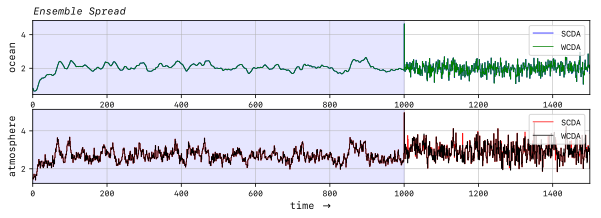

In [9]:
#check for spread of ensemble
dev_oceS = [np.std(col) for col in oce_for_saveS.T]
dev_atmS = [np.std(col) for col in atm_for_saveS.T]
dev_oceW = [np.std(col) for col in oce_for_saveW.T]
dev_atmW = [np.std(col) for col in atm_for_saveW.T]

plt.figure(figsize=(10,3),dpi=100);
plt.subplot(2, 1, 1);
plt.plot(dev_oceS, c='b', linewidth=0.75, drawstyle='steps-post')
plt.plot(dev_oceW, c='g', linewidth=0.75, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
ax.set_title('Ensemble Spread',fontproperties=fontit,fontsize=10,loc='left');
ax.autoscale(enable=True, axis='x', tight=True);
#ax.set_yscale('log'); 
plt.ylabel('ocean',fontproperties=font,fontsize=10);
plt.axvspan(0, (ini + CoolOff), alpha=0.1, color='blue');
l1 = ax.legend(['SCDA','WCDA'], loc='upper right', ncol=1)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
fontsmall = fm.FontProperties(fname = fontloc,size = 6)
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);

plt.subplot(2, 1, 2);
plt.plot(dev_atmS, c='r', linewidth=0.75, drawstyle='steps-post')
plt.plot(dev_atmW, c='k', linewidth=0.75, drawstyle='steps-post')
ax = gca(); ticks(ax,8); plt.grid(linewidth=0.5); 
ax.autoscale(enable=True, axis='x', tight=True);
plt.xlabel(r'time $\rightarrow$',fontproperties=font,fontsize=10);
plt.ylabel('atmosphere',fontproperties=font,fontsize=10);
plt.axvspan(0, (ini + CoolOff), alpha=0.1, color='blue');
l1 = ax.legend(['SCDA','WCDA'], loc='upper right', ncol=1)
plt.setp(l1.texts, family='SF Mono', fontsize=8);
#ax.set_yscale('log'); 
ax.grid(b=True, which='minor', linewidth=0.10, linestyle='--')
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.2g'));
fontsmall = fm.FontProperties(fname = fontloc,size = 6)
plt.setp(ax.get_yticklabels(which='minor'), fontproperties=fontsmall);


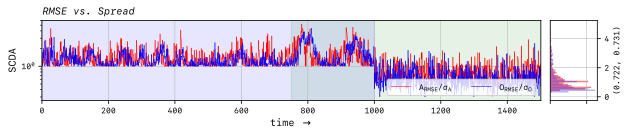

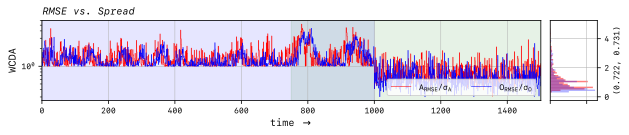

In [10]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10,2), dpi=100);
gs = GridSpec(4,10)
ax_joint = fig.add_subplot(gs[1:4,0:9])
ax_marg_y = fig.add_subplot(gs[1:4,9])

A_S = np.divide(atm_rmseS,dev_atmS)
O_S = np.divide(oce_rmseS,dev_oceS)
binwidth = 0.10; bin_off = 0.0;
bins = np.arange(0.0 - bin_off, 5.0 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2

halfit = int(len(O_S)/2)
ax_joint.plot(A_S, c='r', linewidth=0.5, drawstyle='steps-post', linestyle='-')
ax_joint.plot(O_S, c='b', linewidth=0.5, drawstyle='steps-post', linestyle='-')
l1 = ax_joint.legend([r'$\mathregular{A_{RMSE}/\sigma_{A}}$', r'$\mathregular{O_{RMSE}/\sigma_{O}}$'], loc='lower right', ncol=2)
ax_joint.set_title(r'RMSE vs. Spread',fontproperties=fontit,fontsize=10,loc='left');
ticks(ax_joint,8); ax_joint.grid(linewidth=0.5); 
ax_joint.autoscale(enable=True, axis='x', tight=True);
ax_joint.set_xlabel(r'time $\rightarrow$',fontproperties=font,fontsize=10);
ax_joint.set_ylabel(r'SCDA',fontproperties=font,fontsize=10);
ax_joint.axvspan(0, ini + CoolOff, alpha=0.1, color='blue');
ax_joint.axvspan(halfit, len(A_S), alpha=0.1, color='green');
plt.setp(l1.texts, family='SF Mono', fontsize=8);
stdO  = np.std(O_S[halfit:-1]); stdA = np.std(A_S[halfit:-1])
ax_marg_y.hist(A_S[halfit:-1], bins = bins, orientation="horizontal",alpha=0.5, density=False, facecolor='red', linewidth=0.00)
ax_marg_y.hist(O_S[halfit:-1], bins = bins, orientation="horizontal",alpha=0.3, density=False, facecolor='blue', linewidth=0.00)
plt.setp(ax_marg_y.get_yticklabels(), visible=True); plt.setp(ax_marg_y.get_xticklabels(), visible=False)
ax_marg_y.yaxis.tick_right()
ax_marg_y.grid(linewidth=0.5); ticks(ax_marg_y,8);
#lim = ax_joint.get_ylim(); ax_marg_y.set_ylim(lim); 
ax_marg_y.set_ylabel(r'($\mathregular{%1.3f}}$, $\mathregular{%1.3f}}$)' % (stdO, stdA),fontproperties=font,fontsize=8);
ax_marg_y.yaxis.set_label_position("right")
ax_joint.set_yscale('log');

fig = plt.figure(figsize=(10,2), dpi=100);
gs = GridSpec(4,10)
ax_joint = fig.add_subplot(gs[1:4,0:9])
ax_marg_y = fig.add_subplot(gs[1:4,9])

A_W = np.divide(atm_rmseW,dev_atmW)
O_W = np.divide(oce_rmseW,dev_oceW)
ax_joint.plot(A_W, c='r', linewidth=0.5, drawstyle='steps-post', linestyle='-')
ax_joint.plot(O_W, c='b', linewidth=0.5, drawstyle='steps-post', linestyle='-')
l1 = ax_joint.legend([r'$\mathregular{A_{RMSE}/\sigma_{A}}$', r'$\mathregular{O_{RMSE}/\sigma_{O}}$'], loc='lower right', ncol=2)
ax_joint.set_title(r'RMSE vs. Spread',fontproperties=fontit,fontsize=10,loc='left');
ticks(ax_joint,8); ax_joint.grid(linewidth=0.5); 
ax_joint.autoscale(enable=True, axis='x', tight=True);
ax_joint.set_xlabel(r'time $\rightarrow$',fontproperties=font,fontsize=10);
ax_joint.set_ylabel(r'WCDA',fontproperties=font,fontsize=10);
ax_joint.axvspan(0, ini + CoolOff, alpha=0.1, color='blue');
ax_joint.axvspan(halfit, len(A_W), alpha=0.1, color='green');
plt.setp(l1.texts, family='SF Mono', fontsize=8);
stdO  = np.std(O_W[halfit:-1]); stdA = np.std(A_W[halfit:-1])
ax_marg_y.hist(A_W[halfit:-1], bins = bins, orientation="horizontal",alpha=0.5, density=False, facecolor='red', linewidth=0.00)
ax_marg_y.hist(O_W[halfit:-1], bins = bins, orientation="horizontal",alpha=0.3, density=False, facecolor='blue', linewidth=0.00)
plt.setp(ax_marg_y.get_yticklabels(), visible=True); plt.setp(ax_marg_y.get_xticklabels(), visible=False)
ax_marg_y.yaxis.tick_right()
ax_marg_y.grid(linewidth=0.5); ticks(ax_marg_y,8);
#lim = ax_joint.get_ylim(); ax_marg_y.set_ylim(lim);
ax_marg_y.set_ylabel(r'($\mathregular{%1.3f}}$, $\mathregular{%1.3f}}$)' % (stdO, stdA),fontproperties=font,fontsize=8);
ax_marg_y.yaxis.set_label_position("right"); 
ax_joint.set_yscale('log');